# **White Male Effect - Understanding America Study**
## Ekim Luo
*Last Updated: July 16, 2021*

# **Data**
- [Understanding America Study](https://uasdata.usc.edu/index.php) COVID-19 National Survey Data, Center for Economic and Social Research, University of Southern California
    - Original data: March 10, 2020 - June 22, 2021 (28 waves)
    - My data: April 1, 2020 - June 22, 2021 (27 waves)

# **Setting up**

In [1]:
# version check
import sys
sys.version

'3.8.10 (default, Jun  4 2021, 15:09:15) \n[GCC 7.5.0]'

In [2]:
# import packages.
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt # graphing
import matplotlib.patches as mpatches 
from matplotlib.ticker import FuncFormatter, MaxNLocator
from matplotlib.lines import Line2D
import matplotlib.ticker as plticker # force display all x-axis labels 
import seaborn as sns # set context 

In [3]:
# import uas data
df = pd.read_csv('uas.csv', low_memory = False)

In [4]:
# preview dataset
df.tail()

,uasid,uashhid,survhhid,wave,survey_source,uasmembers,final_weight,sampletype,primary_respondent,hardware,...,vc004d,vc005_randomizer,vc005a,vc005b,vc005c,vd001,vd002,vd003,vd004,cs_001
173818,210400002,190402019,763508828,28,346,1,0.092922,3,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
173819,210400011,180203969,124007544921,28,346,3,1.708786,4,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
173820,210400013,190500388,52804055788890,28,346,4,0.441035,3,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
173821,210400014,190500388,52804055788890,28,346,4,0.488973,3,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
173822,210400019,180811653,727407592,28,346,1,0.520056,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0


# **Cleaning data**

In [5]:
# count the total n of unique individuals before cleaning
len(df['uasid'].unique())

8581

In [6]:
# only include participants that answered "no" to having been diagnosed with covid.
df = df[df['covid_diagnosed'] == 2] 

In [7]:
# exclude pilot wave 1
df = df[df['wave'] != 1] 
# df.drop(df.index[df['wave'] == 1], inplace=True) # alternatively

# **Scoring data**

## **group column**
- White men, White women, non-White men, non-White women

In [8]:
group = [] # create empty list for appending group values 

for i in df[['gender', 'race']].values.tolist(): # loop through the gender and race columns and append group values
    if i[0] == 1 and i[1] == 1: # white male
        group.append('wm') # append value to list 
    elif i[0] == 1 and i[1] != 1: # non-white male
        group.append('nm')
    elif i[0] == 0 and i[1] == 1: # white female
        group.append('ww')
    elif i[0] == 0 and i[1] != 1: # non-white female
        group.append('nw')
    else:
        group.append('NaN') # if the gender or race cells are empty, write in "NaN"

df['group'] = group # append list as a column named group

In [9]:
df = df.loc[df['group'] != 'NaN'] # eliminate 1 row with a missing gender input (wave 2)

## **group2 column**
- White men (1) v. others (0)

In [10]:
df['group2'] = 0 # others
df.loc[lambda df: df['group'] == 'wm',['group2']] = 1 # wm

## **race2 column**
- White (1) v. non-White (0)

In [11]:
df['race2'] = 0 # others
df.loc[lambda df: df['race'] == 1,['race2']] = 1 # white

# **Describing data**

In [12]:
# sample size
# count the total n of unique individuals after cleaning
df['uasid'].nunique()

8296

In [13]:
# attrition
# N indiviuals per wave divided by N sample size
df['wave'].value_counts(sort = False)/len(df['uasid'].unique())

2     0.651037
3     0.747589
4     0.762657
5     0.761210
6     0.761451
7     0.753134
8     0.720468
9     0.743491
10    0.754701
11    0.737705
12    0.742044
13    0.744335
14    0.724807
15    0.722035
16    0.732401
17    0.738790
18    0.716369
19    0.710704
20    0.712150
21    0.709740
22    0.723481
23    0.730352
24    0.748071
25    0.731316
26    0.718539
27    0.715887
28    0.706485
Name: wave, dtype: float64

In [14]:
# count unique individuals by group
df['boolean'] = df['uasid'] .duplicated() # create new column "boolean" with T/F values based on the duplication of uasid
print(df.loc[df['boolean'] == False,'group'].value_counts()) # count rows with F values by group

ww    3688
wm    2692
nw    1224
nm     692
Name: group, dtype: int64


### **Summary statistics**
- age (`age`)
- household income (`hhincome`)
- education (`education`)
- hospitalized how many family or close friends (`cr022a`)
- died how many family or close friends (`cr022b`)
- N days in the past seven worked from home (`jobs_dayswfh`)
- household size (`hhmembernumber`)

First, extract unique individuals from the DataFrame, then calculate summary statistics based on unique individuals. Do this by creating a separate DataFrame that contains the first instance of each unique individual using `drop_duplicates()`.

In [15]:
# create a copy of df
df_unique = df.copy()

In [16]:
# drop duplicates
df_unique.drop_duplicates(subset = 'uasid', inplace = True)
print('There are a total of {0} unique individuals in the new DataFrame.'.format(df_unique.shape[0]))

There are a total of 8296 unique individuals in the new DataFrame.


In [17]:
# subset new dataframe to contain only relevant columns
cols_to_keep = ['age','hhincome','education','cr022a','cr022b','jobs_dayswfh','hhmembernumber']
df_unique = df_unique[cols_to_keep]
df_unique.head()

,age,hhincome,education,cr022a,cr022b,jobs_dayswfh,hhmembernumber
6932,36.0,15.0,14.0,NaN,NaN,5.0,3.0
6933,44.0,15.0,11.0,NaN,NaN,5.0,3.0
6934,30.0,13.0,9.0,NaN,NaN,0.0,4.0
6935,70.0,13.0,10.0,NaN,NaN,NaN,1.0
6936,59.0,12.0,13.0,NaN,NaN,0.0,0.0


In [18]:
# calculate summary descriptives
# note that 50% quantile = median
df_unique.describe()

,age,hhincome,education,cr022a,cr022b,jobs_dayswfh,hhmembernumber
count,8288.000000,8275.000000,8294.000000,2652.000000,2649.000000,4314.000000,8022.000000
mean,49.294402,11.242296,11.311912,0.208899,0.110608,2.477283,1.721640
std,16.302837,4.174453,2.276129,1.385144,1.512110,2.649485,1.450141
min,18.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,36.000000,9.000000,10.000000,0.000000,0.000000,0.000000,1.000000
50%,49.000000,13.000000,11.000000,0.000000,0.000000,1.000000,1.000000
75%,62.000000,15.000000,13.000000,0.000000,0.000000,5.000000,3.000000
max,110.000000,16.000000,16.000000,50.000000,67.000000,7.000000,11.000000


### **Calculating mean perceived risk of COVID-19 mortality by group**

In [19]:
# calculate mean and SD of risk perception by group (death)
print('\n\nmean',df.groupby('group')['prisk_die'].mean())
print('\n\nstd',df.groupby('group')['prisk_die'].std())
print('\n\nssem',df.groupby('group')['prisk_die'].sem())



mean group
nm    17.346123
nw    18.496077
wm    15.107234
ww    17.811527
Name: prisk_die, dtype: float64


std group
nm    23.905954
nw    24.296898
wm    23.882919
ww    24.503345
Name: prisk_die, dtype: float64


ssem group
nm    0.208732
nw    0.162402
wm    0.102573
ww    0.091031
Name: prisk_die, dtype: float64


# **Plotting risk perceptions over time**


## **Calculate Group Means for Plotting**

In [20]:
# 27 waves total (2-28)

nWaves =  28 # NEED TO MANUALLY UPDATE PER WAVE 

# define wave range and group values
xWave = range(1,nWaves+1) 
yGroup = ['wm','ww','nm','nw'] 

# create empty matrices to store wave and group values
priskDie =np.zeros((nWaves,4))

# calculate group means and append to empty matrices
for i in xWave: 
 for j in range(4): 
    meanDie = df.loc[(df['wave'] == i) & (df['group'] == yGroup[j]), 'prisk_die'].mean()
    priskDie[i-1,j] = meanDie

for i in range(1, nWaves+1):
  for j in range(len(yGroup)):
    meanDie = df.loc[(df['wave'] == i) & (df['group'] == yGroup[j]), 'prisk_die'].mean()
    priskDie[i-1, j] = meanDie

print(priskDie)
len(priskDie)

[[        nan         nan         nan         nan]
 [22.78782051 26.23386622 23.42546296 22.20635593]
 [19.55311005 23.1413004  21.31730382 22.00130797]
 [18.5985782  21.25046296 20.73191489 21.28025404]
 [17.50878443 20.54657534 18.44330097 20.93047509]
 [17.11588292 19.62976744 20.04519231 19.47571266]
 [16.26354016 19.19269091 18.18271845 19.13050058]
 [16.5063678  19.54401343 17.90649895 19.40183599]
 [16.54367367 19.49985262 18.64990138 19.9056582 ]
 [16.42944874 18.71909091 18.48420039 19.96773823]
 [16.3509172  18.84194383 17.37955466 19.04267292]
 [15.67025692 17.86477024 17.79307536 18.05567503]
 [15.42097561 17.65548221 18.17489879 18.43309942]
 [15.62667004 17.56846442 17.77958333 18.53759124]
 [15.04451158 17.34127225 17.89       19.03837772]
 [14.62306153 17.24731581 17.10698152 18.69892857]
 [14.76268509 17.07942478 17.37657841 18.51627358]
 [15.28078292 17.74831758 16.91670282 18.7361754 ]
 [14.41847328 17.80091778 16.5691974  17.84822785]
 [14.13104693 17.2411922  16.41

28

In [21]:
# check wave range
range(nWaves-1)

range(0, 27)

In [22]:
# labeling plot

wave_times = ['2020',
'Apr 1 - Apr 28',
'Apr 15 – May 13',
'Apr 29 – May 26',
'May 13 - June 9',
'May 27 - June 23',
'June 10 - Jul 8',
'June 24 - Jul 22',
'July 8 - Aug 5',
'July 22 - Aug 19',
'Aug 5 - Sep 2',
'Aug 19 - Sep 16',
'Sep 2 - Sep 30',
'Sep 16 - Oct 14',
'Sep 30 - Oct 27',
'Oct 14 - Nov 11',
'Oct 28 - Nov 25',
'Nov 11 - Dec 9',
'Nov 25 - Dec 23',
'Dec 9 - Jan 6',
'Dec 23 - Jan 20',
'Jan 6 - Feb 3',
'Jan 20 - Feb 17',
'Feb 2  - Mar 3', 
'Feb 17 - Mar 30',
'Mar 17 - Apr 27',
'Apr 14 - May 25',
'May 12 - Jun 22',
'2021']

In [23]:
# create function for ticks
def format_fn(tick_val, tick_pos):
    if int(tick_val) in range(nWaves+1):
        return wave_times[int(tick_val)]
    else:
        return ''

## **Perceived risk of COVID-19 death**

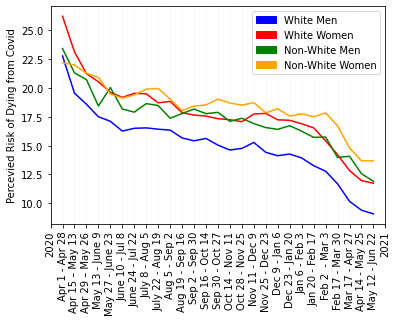

In [24]:
# plot mean perceived risk of COVID-19 mortality over time
ax = plt.subplot(111)
ax.xaxis.set_major_formatter(FuncFormatter(format_fn))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_xlim((0, 28))

loc = plticker.MultipleLocator(base=1.0) # enforces regular intervals on the x-axis
ax.xaxis.set_major_locator(loc)

ax.plot(priskDie[:,0],color='blue')
ax.plot(priskDie[:,1],color='red')
ax.plot(priskDie[:,2],color='green')
ax.plot(priskDie[:,3],color='orange')

barBlue = mpatches.Patch(color='blue', label='White Men')
barRed = mpatches.Patch(color='red', label='White Women')
barGreen = mpatches.Patch(color='green', label='Non-White Men')
barOrange = mpatches.Patch(color='orange', label='Non-White Women')

plt.legend(handles=[barBlue, barRed, barGreen, barOrange])
plt.ylabel('Percevied Risk of Dying from Covid')
plt.xticks(rotation=90) # tilt x-axis labels

for i in range(nWaves):
  plt.axvline(x=i,color='red',alpha=0.05,linewidth=0.7)
  plt.plot()

plt.show()
plt.rcParams['figure.figsize'] = [20 , 12] # specify figure size

# **Exporting scored data**
- Analyze data in R.

## **Full data**

In [25]:
# df.to_csv('uas_cleaned_full.csv') # export processed dataset as a csv file

## **Subset data to include participants who responded to more than 1 wave**

In [26]:
# include only those who responded to more than 1 wave
df_morethan1 = df[df.groupby('uasid').uasid.transform(len) > 1]

In [27]:
# count sample size by group
df_morethan1['boolean'] = df_morethan1['uasid'] .duplicated() # create new column "boolean" with T/F values based on the duplication of uasid
print(df_morethan1.loc[df_morethan1['boolean'] == False,'group'].value_counts()) # count rows with F values by group

ww    3616
wm    2638
nw    1199
nm     674
Name: group, dtype: int64


/home/ekim/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [28]:
# count N of participants who responded to more than 1 wave
df_morethan1['uasid'].nunique()

8127

In [29]:
# export to csv
# df_morethan1.to_csv('uas_morethan1wave.csv')

## **Subset data to include participants who only responded to 1 wave**

In [30]:
# include those who responded to 1 wave only
df_only1 = df[df.groupby('uasid').uasid.transform(len) == 1]

In [31]:
# count sample size by group
df_only1['boolean'] = df_only1['uasid'] .duplicated() # create new column "boolean" with T/F values based on the duplication of uasid
print(df_only1.loc[df_only1['boolean'] == False,'group'].value_counts()) # count rows with F values by group

ww    72
wm    54
nw    25
nm    18
Name: group, dtype: int64


In [32]:
# count N of participants who responded to more than 1 wave
df_only1['uasid'].nunique()

169

In [33]:
# export to csv
# df_only1.to_csv('uas_only1wave.csv')

In [34]:
print('There are a total of {0} individuals who responded to at least one wave. Out of these individuals, {1} individuals responded to more than one wave, and {2} individuals responded to only one wave.'.format(df['uasid'].nunique(), df_morethan1['uasid'].nunique(), df_only1['uasid'].nunique()))

There are a total of 8296 individuals who responded to at least one wave. Out of these individuals, 8127 individuals responded to more than one wave, and 169 individuals responded to only one wave.
